In [84]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
import time
from matplotlib import rcParams
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.family': 'sans-serif',
         'text.usetex': False}
rcParams.update(params)
#%matplotlib notebook
%matplotlib 

class agg_diff_PDE_2D:
    
    def __init__(self,Lx,Ly,Nx,Ny,dt,diff_H,V,W,init_rho,tmax):
        self.Lx = Lx
        self.Nx = Nx
        self.Ly = Ly
        self.Ny = Ny
        self.V = V
        self.dt = dt
        self.diff_H = diff_H
        self.W = W
        self.dx = Lx/Nx
        self.dy = Ly/Ny
        self.tmax = tmax
        self.chalf_x = np.linspace(-Lx,Lx,int(2*Nx+1))
        self.cspan_x = np.linspace(-Lx + self.dx/2, Lx - self.dx/2, int(2*Nx))
        self.chalf_y = np.linspace(-Ly,Ly,int(2*Ny+1))
        self.cspan_y = np.linspace(-Ly + self.dy/2, Ly - self.dy/2, int(2*Ny))
        self.X, self.Y = np.meshgrid(self.cspan_x,self.cspan_y)
        self.rho = [init_rho]
        self.rho_ex = [np.concatenate([x for x in init_rho])]
        self.W_mat = np.array([[W(x-self.X,y-self.Y) for x in self.cspan_x] for y in self.cspan_y])
      
    def splitter(self,rho_expanded):
        return np.array(np.split(rho_expanded,2*self.Nx))
    
    def disc_entropy(self,f):
        return self.diff_H(f) + self.V(self.X,self.Y) + np.array([[np.sum(np.multiply(w,f)) for w in ww] for ww in self.W_mat])*self.dx*self.dy
    
    def velocities_x(self,h):
        return -(h[1:,:]-h[:-1,:])/self.dx
    
    def velocities_y(self,h):
        return -(h[:,1:]-h[:,:-1])/self.dy
    
    def flux_x(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:-1,:]*np.maximum(v,zero_vec) + g[1:,:]*np.minimum(v,zero_vec)
        #F = (g[:-1,:] + g[1:,:])/2*v
        return np.concatenate([[np.zeros(len(F[0]))],F,[np.zeros(len(F[0]))]])
    
    def flux_y(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:,:-1]*np.maximum(v,zero_vec) + g[:,1:]*np.minimum(v,zero_vec)
        #F = (g[:,:-1] + g[:,1:])/2*v
        return np.transpose(np.concatenate([[np.zeros(len(F))],np.transpose(F),[np.zeros(len(F))]]))
    
    def dpdt(self,t,p_expanded):
        p = self.splitter(p_expanded)
        h = self.disc_entropy(p)
        Fx = self.flux_x(self.velocities_x(h),p)
        Fy = self.flux_y(self.velocities_y(h),p)
        diff = -(Fx[1:,:]-Fx[:-1,:])/self.dx-(Fy[:,1:]-Fy[:,:-1])/self.dy
        return np.concatenate([x for x in diff])
    
    def euler(self):
        t = 0
        while t < self.tmax:
            t += self.dt
            self.rho.append(self.dt*self.dpdt(t,self.rho[-1]) + self.rho[-1])
        return np.array(self.rho)
    
    
    def solve(self):
        solODE = ode(self.dpdt).set_integrator('dopri5')
        solODE.set_initial_value(self.rho_ex[0],0)
        t = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            self.rho.append(self.splitter(solODE.integrate(t)))
        return np.array(self.rho)

Using matplotlib backend: nbAgg


In [74]:
Nx = 40
Ny = 40
Lx = 4
Ly = 4
dt = .05
tmax = 15
dx = Lx/Nx
dy = Ly/Ny
print(dx,dy)
xspan = np.linspace(-Lx + dx/2, Lx - dx/2, int(2*Nx))
yspan = np.linspace(-Ly + dy/2, Ly - dy/2, int(2*Ny))

X,Y = np.meshgrid(xspan,yspan)

def diff_H(f):
    v,m = 0.1,3
    return v*f**(m-1)

def pot_V(x,y):
    return -x**2*0-y**2*0

def ex_W(x,y):
    return -np.exp(-x**2-y**2)/np.pi*0

init_rho = np.array([[1 if i**2 + j**2 < 9 else 0 for i in xspan] for j in yspan])
init_rho = np.array([[1/4 if abs(i) < 3 and abs(j) < 3 else 0 for i in xspan] for j in yspan])
#init_rho = np.exp(-X**2-Y**2)*0.2

solver = agg_diff_PDE_2D(Lx,Ly,Nx,Ny,dt,diff_H,pot_V,ex_W,init_rho,tmax)
h = solver.disc_entropy(init_rho)
vx = solver.velocities_x(h)
vy = solver.velocities_y(h)
Fx = solver.flux_x(vx,init_rho)
Fy = solver.flux_y(vy,init_rho)
rho_sol = solver.solve()

0.1 0.1


<IPython.core.display.Javascript object>


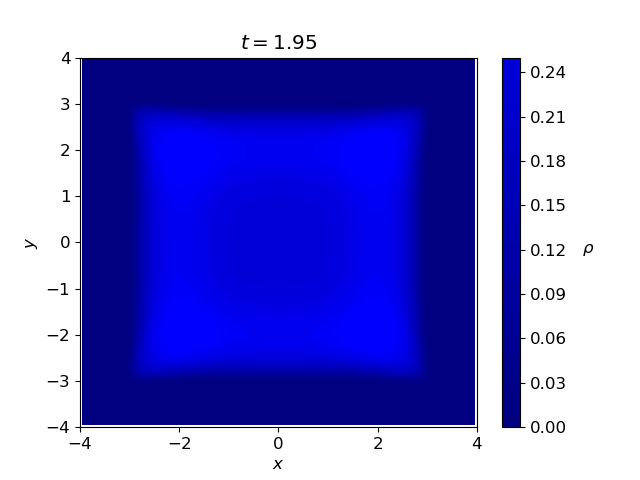

KeyboardInterrupt: 

In [81]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%1 == 0]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
ax.set_xlim(-Lx,Lx)
ax.set_ylim(-Ly,Ly)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.canvas.draw()
ncont = 50
tspan = np.linspace(0,tmax,len(rho))
sc = ax.contourf(X,Y,rho[0],ncont,cmap = 'jet',vmin = 0,vmax = np.max(np.concatenate([r for r in rho])))
cb = fig.colorbar(sc,ax = ax)
cb.set_label('$\\rho$',rotation = 0,labelpad = 15)
for i in range(len(rho)):
    ax.contourf(X,Y,rho[i],ncont,cmap = 'jet',vmin = 0,vmax = np.max(np.concatenate([r for r in rho])))
    ax.set_title('$t = %.2f$' % tspan[i])
    fig.canvas.draw()
    del ax.collections[:]
    del ax.lines[:]
ax.contourf(X,Y,rho[-1],ncont,cmap = 'Blues',vmin = 0,vmax = np.max(np.concatenate([r for r in rho])))
plt.show()

<IPython.core.display.Javascript object>


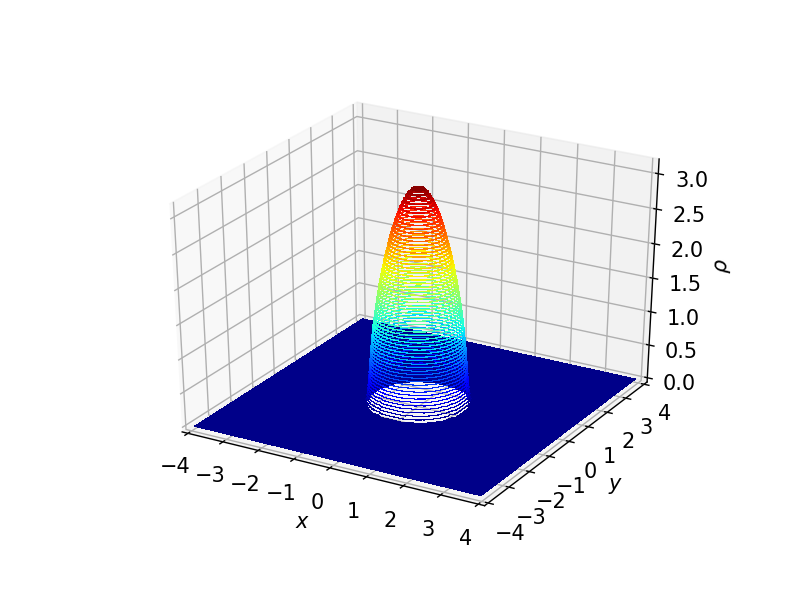

In [89]:
from mpl_toolkits.mplot3d import Axes3D
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%15 == 0]
fig = plt.figure()
ax = plt.axes(projection = '3d')
plt.ion()
fig.show()
ax.set_xlim(-Lx,Lx)
ax.set_ylim(-Ly,Ly)
ax.set_zlim(0,np.max(np.concatenate([r for r in rho])))
ax.set_zlabel('$\\rho$')
ax.set_zlabel(ax.get_zlabel(), rotation=270)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.canvas.draw()
ncont = 70
tspan = np.linspace(0,tmax,len(rho))
sc = ax.contourf3D(X,Y,rho[0],ncont,cmap = 'jet')
for i in range(len(rho)):
    ax.contourf3D(X,Y,rho[i],ncont,cmap = 'jet')
    #ax.set_title('$t = %.2f$' % tspan[i])
    fig.canvas.draw()
    del ax.collections[:]
    del ax.lines[:]
ax.contourf3D(X,Y,rho[-1],ncont,cmap = 'jet')
plt.show()

In [ ]:
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

fig = plt.figure()
ax = p3.Axes3D(fig)

def gen(n):
    phi = 0
    while phi < 2*np.pi:
        yield np.array([np.cos(phi), np.sin(phi), phi])
        phi += 2*np.pi/n

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

N = 100
data = np.array(list(gen(N))).T
line, = ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1])

# Setting the axes properties
ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 10.0])
ax.set_zlabel('Z')

ani = animation.FuncAnimation(fig, update, N, fargs=(data, line), interval=10000/N, blit=False)
#ani.save('matplot003.gif', writer='imagemagick')